In [25]:
using PyPlot
using BenchmarkTools
using Interp1d
using SciPy

# Interpolation examples

## Nearest interpolation

In [3]:
@doc(interp)

```
interp(xi::Vector{T}, yi::Vector{T}, ::Type{Nearest}; copy=true, sorted=false) where T
interp(xi::Vector{T}, yi::Matrix{T}, ::Type{Nearest}; copy=true, sorted=false) where T
```

Returns a nearest interpolation function `f(x)` based on interpolated points `xi` and `yi`.

If `xi` has a duplicated value, `ArgumentError` is thrown.

If `copy` is true, this function makes internal copies of `xi` and `yi`, otherwise it uses references.

If `sorted` is false, this function sorts `xi` first, otherwise it assumes `xi` is monotonically increasing. 

# Examples

This is a simple interpolation example:

```jldoctest
julia> using Interp1d

julia> xi = [-1.0, 0.0, 3.0/2.0];

julia> yi = [2.0, 1.0, 3.0];

julia> f = interp(xi, yi, Nearest);

julia> f(1.0)
3.0
```

`yi` can be matrix for multi univerate interpolations. The number of rows of `yi` must be equal to the length of `xi`.

```jldoctest
julia> using Interp1d

julia> xi = [-1.0, 0.0, 3.0/2.0];

julia> yi = [ 2.0  1.0 3.0;
             -1.0 -4.4 2.0];

julia> f = interp(xi, yi, Nearest);

julia> f(0.0)
2-element Vector{Float64}:
  1.0
 -4.4
```


### 1 input vs 1 output example

In [47]:
x = [-1.0, 0.0, 3.0/2.0];
y = [2.0, 1.0, 3.0];
f = interp(x, y, Nearest);
f(1.0)

3.0

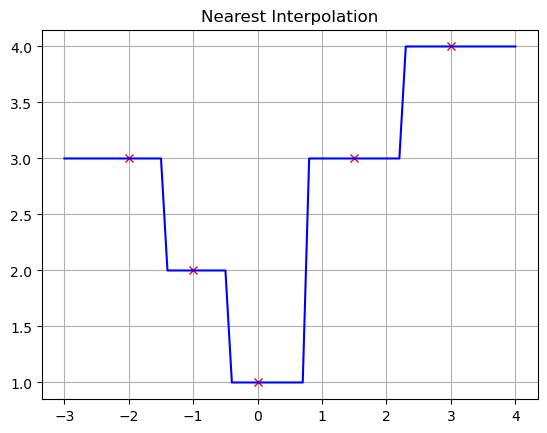

In [48]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Nearest);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");
title("Nearest Interpolation");

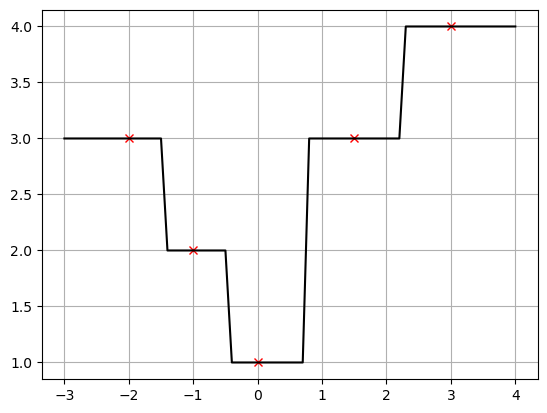

In [49]:
sf = interpolate.interp1d(x, y, kind="nearest", fill_value="extrapolate")
siy = sf(ix)
plot(x, y, "xr");
plot(ix, siy, "-k", label="SciPy interp1d");

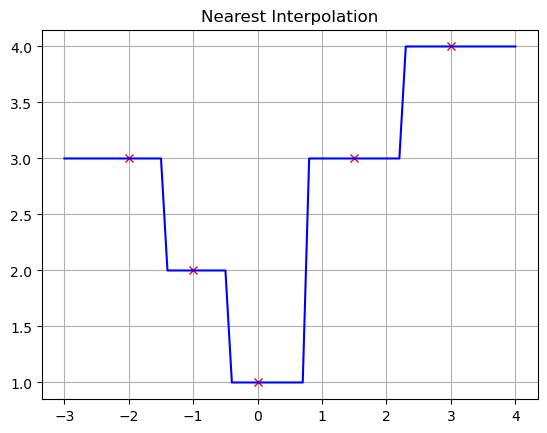

In [50]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Nearest);
plot(x, y, "xr");
y[3] = 5.0
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(ix, iy, "-b");
title("Nearest Interpolation");

### 1 input vs 2 output example

In [51]:
x = [-1.0, 0.0, 3.0/2.0];
y = [2.0 1.0 3.0;
    -1.0 -4.4 2.0];
f = interp(x, y, Nearest);
f(0.0)

2-element Vector{Float64}:
  1.0
 -4.4

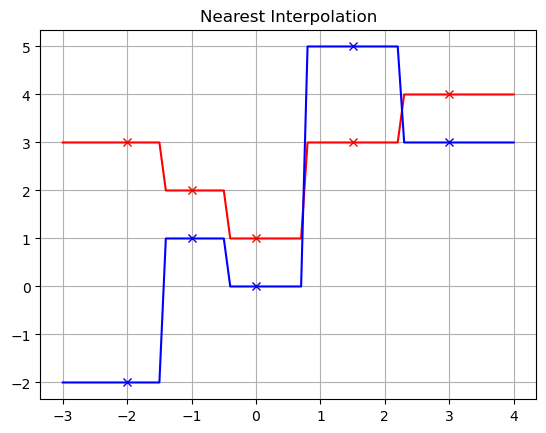

In [52]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0 2.0 1.0 3.0 4.0;
    -2.0 1.0 0.0 5.0 3.0];
f = interp(x, y, Nearest);
ix = collect(-3.0:0.1:4.0);
iy = hcat(f.(ix)...);
plot(x, y[1,:], "xr");
plot(x, y[2,:], "xb");
plot(ix, iy[1,:], "-r");
plot(ix, iy[2,:], "-b");
title("Nearest Interpolation");

# Previous

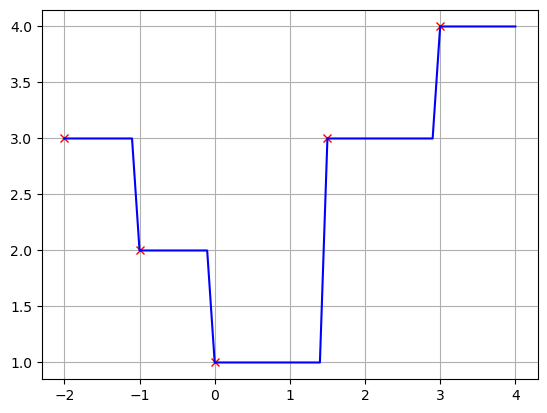

In [7]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Previous);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

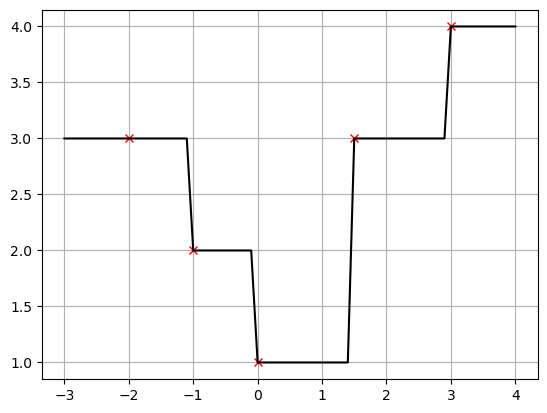

In [8]:
sf = interpolate.interp1d(x, y, kind="previous", fill_value="extrapolate")
siy = sf(ix)
plot(x, y, "xr");
plot(ix, siy, "-k", label="SciPy interp1d");

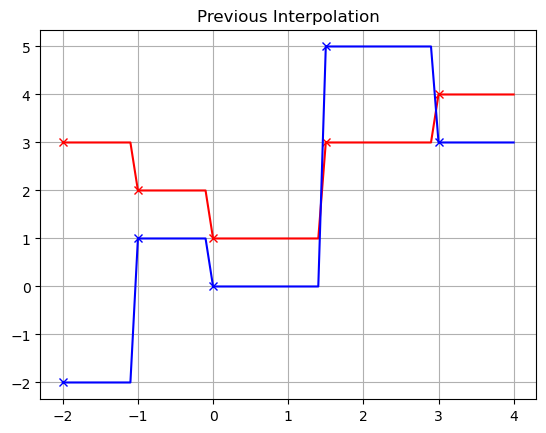

In [11]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0 2.0 1.0 3.0 4.0;
    -2.0 1.0 0.0 5.0 3.0];
f = interp(x, y, Previous);
ix = collect(-2.0:0.1:4.0);
iy = hcat(f.(ix)...);
plot(x, y[1,:], "xr");
plot(x, y[2,:], "xb");
plot(ix, iy[1,:], "-r");
plot(ix, iy[2,:], "-b");
title("Previous Interpolation");

## Next補間

In [5]:
abstract type Next <: InterpMode end

function interp(xi::Vector{T}, yi::Vector{T}, ::Type{Next}) where T
    function f(x)
        x >= xi[end] && return nothing
        idx = searchsortedlast(xi, x)
        idx < 1 && (idx = 1)
        return yi[idx]
    end
    return f
end

LoadError: UndefVarError: InterpMode not defined

In [6]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Next);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

## Linear補間

In [7]:
abstract type Linear <: InterpMode end

abstract type ExtrapolateMode end
abstract type Extrapolate <: ExtrapolateMode end
abstract type FillNearest <: ExtrapolateMode end
abstract type FillNothing <: ExtrapolateMode end

function interp(xi::Vector{T}, yi::Vector{T}, ::Type{Linear}, extmode::Type{<:ExtrapolateMode}) where T
    function f(x)
        idx = searchsortedlast(xi, x)
        if extmode == Extrapolate
            idx < 1 && (idx = 1)
            idx >= length(xi) && (idx = length(xi)-1)
        elseif extmode == FillNearest
            idx < 1 && (return yi[1])
            idx >= length(xi) && (return yi[end])
        elseif extmode == FillNothing
            idx < 1 && (return nothing)
            idx >= length(xi) && (return nothing)
        end
        return ((x-xi[idx])*yi[idx+1]-(x-xi[idx+1])*yi[idx])/(xi[idx+1]-xi[idx])
    end
    return f
end

interp(xi::Vector{T}, yi::Vector{T}, ::Type{Linear}) where T = interp(xi::Vector{T}, yi::Vector{T}, Linear, Extrapolate) 

LoadError: UndefVarError: InterpMode not defined

In [8]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Linear);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

In [9]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Linear, Extrapolate);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

In [10]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Linear, FillNearest);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

In [11]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Linear, FillNothing);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

## Vandermonde行列による補間

In [12]:
function vandermonde(V::Vector{T}) where T
    n=size(V, 1)
    M=Array{T}(undef, n, n)
    M[:,1] .= 1
    for j=2:n, i=1:n
        M[i,j] = M[i,j-1]*V[i]
    end
    return M
end

vandermonde (generic function with 1 method)

In [13]:
vandermonde([1.0,2.0,3.0])

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  2.0  4.0
 1.0  3.0  9.0

In [14]:
abstract type Vandermonde <: InterpMode end

function interp(x::Vector{T}, y::Vector{T}, ::Type{Vandermonde}) where T
    a = vandermonde(x)\y
    f(x) = evalpoly(x, a)
    return f
end

LoadError: UndefVarError: InterpMode not defined

In [15]:
x = [-2, -1, 0];
y = [-3, 2, 1];
f = interp(x, y, Vandermonde);
ix = collect(-3.0:0.1:1.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

In [16]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Vandermonde);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

## ラグランジュ補間

In [17]:
abstract type Lagrange <: InterpMode end

function interp(xi::Vector{T}, yi::Vector{T}, ::Type{Lagrange}) where T
    
    function f(x)
        p=0.0
        for i in 1:length(xi)
            tmp = 1.0
            for j in 1:length(xi)
                j == i && continue
                tmp *= (x-xi[j])/(xi[i]-xi[j])
            end
            p+=(tmp*yi[i])
        end
        return p
    end
        
    return f
end

LoadError: UndefVarError: InterpMode not defined

In [18]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, Lagrange);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

# CubicSpline

In [19]:
abstract type CubicSpline <: InterpMode end

function interp(xi::Vector{T}, yi::Vector{T}, ::Type{CubicSpline}) where T
    ndata = length(xi)
    coeffmat = zeros(4, ndata)
    w = zeros(ndata)
    coeffmat[1, :] = yi[:]
    dxi = diff(xi)
   
    for i=2:ndata-1
        coeffmat[3, i] = 3.0*(coeffmat[1, i-1]-2.0*coeffmat[1, i]+coeffmat[1, i+1])
    end
    for i=2:ndata
        tmp=4.0-w[i-1]
        coeffmat[3, i] = (coeffmat[3, i]-coeffmat[3, i-1])/tmp
        w[i] = 1.0/tmp
    end
    for i=(ndata-1):-1:1
        coeffmat[3, i] = coeffmat[3, i]-coeffmat[3, i+1]*w[i]
    end
    for i=1:ndata-1
        coeffmat[4, i] = (coeffmat[3, i+1]-coeffmat[3, i])/3.0
        coeffmat[2, i] = coeffmat[1, i+1]-coeffmat[1, i]-coeffmat[3, i]-coeffmat[4, i]
    end
    
    function f(x)
        idx = searchsortedlast(xi, x)
        idx == 0 && (idx=1)
        idx > length(xi)-1 && (idx = length(xi)-1)
        dt = (x-xi[idx])/dxi[idx]
        return evalpoly(dt, coeffmat[:, idx])
    end
        
    return f
end

LoadError: UndefVarError: InterpMode not defined

In [20]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
f = interp(x, y, CubicSpline);
ix = collect(-3.0:0.1:4.0);
iy = f.(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

LoadError: UndefVarError: interp not defined

In [21]:
struct CubicSplineInterp 
    xi::Vector{AbstractFloat}
    yi::Vector{AbstractFloat}
    ndata::Int
    coeffmat::AbstractMatrix
    dxi::Vector{AbstractFloat}
end

function cubic_spline(xi::Vector{T}, yi::Vector{T}) where T
    ndata = length(xi)
    coeffmat = zeros(4, ndata)
    w = zeros(ndata)
    coeffmat[1, :] = yi[:]
    dxi = diff(xi)
   
    for i=2:ndata-1
        coeffmat[3, i] = 3.0*(coeffmat[1, i-1]-2.0*coeffmat[1, i]+coeffmat[1, i+1])
    end
    for i=2:ndata
        tmp=4.0-w[i-1]
        coeffmat[3, i] = (coeffmat[3, i]-coeffmat[3, i-1])/tmp
        w[i] = 1.0/tmp
    end
    for i=(ndata-1):-1:1
        coeffmat[3, i] = coeffmat[3, i]-coeffmat[3, i+1]*w[i]
    end
    for i=1:ndata-1
        coeffmat[4, i] = (coeffmat[3, i+1]-coeffmat[3, i])/3.0
        coeffmat[2, i] = coeffmat[1, i+1]-coeffmat[1, i]-coeffmat[3, i]-coeffmat[4, i]
    end
        
    return CubicSplineInterp(xi, yi, ndata, coeffmat, dxi)
end

function interp(x::T, interp::CubicSplineInterp) where T
    idx = searchsortedlast(interp.xi, x)
    idx == 0 && (idx=1)
    idx > interp.ndata-1 && (idx = interp.ndata-1)
    dt = (x-interp.xi[idx])/interp.dxi[idx]
    return evalpoly(dt, interp.coeffmat[:, idx])
end

interp (generic function with 1 method)

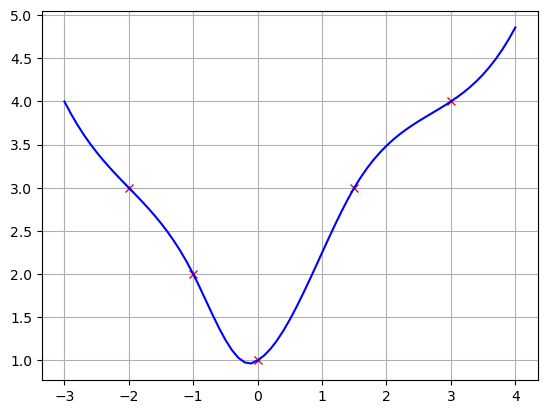

In [22]:
x = [-2.0, -1.0, 0.0, 3.0/2.0, 3.0];
y = [3.0, 2.0, 1.0, 3.0, 4.0];
inter = cubic_spline(x, y);
ix = collect(-3.0:0.1:4.0);
iy = interp.(ix, Ref(inter));
plot(x, y, "xr");
plot(ix, iy, "-b");

# Debug with Scipy

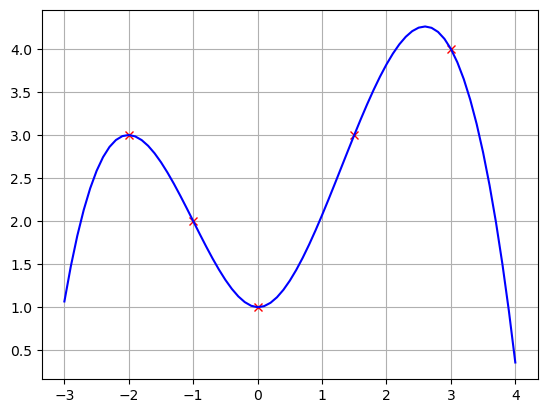

In [23]:
f = interpolate.interp1d(x, y, kind="cubic", fill_value="extrapolate")
ix = collect(-3.0:0.1:4.0);
iy = f(ix);
plot(x, y, "xr");
plot(ix, iy, "-b");

# benchmark

## inner function vs struct

In [24]:
x = collect(-2.0:0.1:3.0);
y = sin.(x);
ix = collect(-3.0:0.0001:4.0);

In [25]:
f = interp(x, y, CubicSpline);
@benchmark iy = f.($ix)

LoadError: UndefVarError: CubicSpline not defined

In [26]:
inter = cubic_spline(x, y);

In [27]:
@benchmark iy = interp.($ix, Ref($inter))

BenchmarkTools.Trial: 
  memory estimate:  19.43 MiB
  allocs estimate:  818512
  --------------
  minimum time:     31.310 ms (0.00% GC)
  median time:      34.413 ms (0.00% GC)
  mean time:        34.663 ms (2.16% GC)
  maximum time:     45.801 ms (0.00% GC)
  --------------
  samples:          145
  evals/sample:     1

In [28]:
@benchmark iy = interp.($ix, ($inter,))

BenchmarkTools.Trial: 
  memory estimate:  19.43 MiB
  allocs estimate:  818511
  --------------
  minimum time:     31.779 ms (0.00% GC)
  median time:      33.741 ms (0.00% GC)
  mean time:        34.025 ms (2.19% GC)
  maximum time:     42.028 ms (0.00% GC)
  --------------
  samples:          147
  evals/sample:     1

## Scipy vs Interp1d

In [26]:
x = collect(-2.0:0.1:3.0);
y = sin.(x);
ix = collect(-2.0:0.0001:3.0);
f = interp(x, y, Previous)
@benchmark iy = f.($ix)

BenchmarkTools.Trial: 
  memory estimate:  392.28 KiB
  allocs estimate:  25
  --------------
  minimum time:     983.624 μs (0.00% GC)
  median time:      1.132 ms (0.00% GC)
  mean time:        1.197 ms (2.68% GC)
  maximum time:     6.565 ms (77.58% GC)
  --------------
  samples:          4175
  evals/sample:     1

In [23]:
f = interpolate.interp1d(x, y, kind="previous", fill_value="extrapolate")
@benchmark iy = f($ix)

BenchmarkTools.Trial: 
  memory estimate:  2.05 KiB
  allocs estimate:  34
  --------------
  minimum time:     29.890 μs (0.00% GC)
  median time:      31.174 μs (0.00% GC)
  mean time:        32.783 μs (0.00% GC)
  maximum time:     481.174 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

# option arg test

## copy

In [21]:
@benchmark f = interp(x, y, Nearest)

BenchmarkTools.Trial: 
  memory estimate:  1.00 KiB
  allocs estimate:  7
  --------------
  minimum time:     330.511 ns (0.00% GC)
  median time:      335.202 ns (0.00% GC)
  mean time:        383.688 ns (8.81% GC)
  maximum time:     11.575 μs (91.52% GC)
  --------------
  samples:          10000
  evals/sample:     223

In [22]:
@benchmark f = interp(x, y, Nearest, copy=false)

BenchmarkTools.Trial: 
  memory estimate:  32 bytes
  allocs estimate:  1
  --------------
  minimum time:     153.984 ns (0.00% GC)
  median time:      155.725 ns (0.00% GC)
  mean time:        163.792 ns (0.84% GC)
  maximum time:     3.379 μs (94.05% GC)
  --------------
  samples:          10000
  evals/sample:     807

## assume_sorted

In [35]:
@benchmark f = interp(x, y, Nearest, assume_sorted=false)

BenchmarkTools.Trial: 
  memory estimate:  1.41 KiB
  allocs estimate:  14
  --------------
  minimum time:     808.602 ns (0.00% GC)
  median time:      911.739 ns (0.00% GC)
  mean time:        1.176 μs (9.25% GC)
  maximum time:     58.966 μs (97.78% GC)
  --------------
  samples:          10000
  evals/sample:     88

In [36]:
@benchmark f = interp(x, y, Nearest, assume_sorted=true)

BenchmarkTools.Trial: 
  memory estimate:  1.00 KiB
  allocs estimate:  8
  --------------
  minimum time:     517.359 ns (0.00% GC)
  median time:      523.880 ns (0.00% GC)
  mean time:        614.883 ns (7.19% GC)
  maximum time:     31.048 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     192

# All interpolation

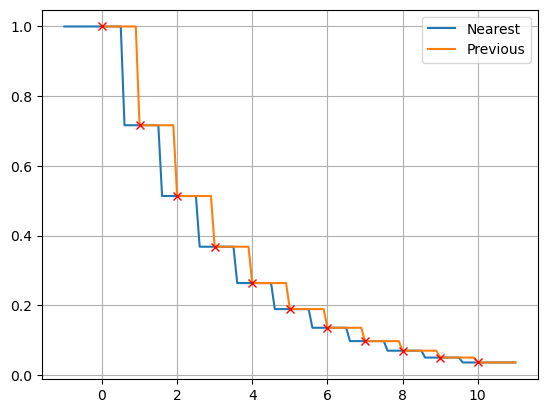

PyObject <matplotlib.legend.Legend object at 0x7f84a033add0>

In [6]:
using Interp1d
using PyPlot
xi = collect(0.0:10.0) # x of interpolated points
yi = exp.(-xi./3.0) # y of interpolated points
x = collect(-1.0:0.1:11.0) # sampling points
for mode in INTERP_MODE_LIST # Do interpolations for all modes.
    f = interp(xi, yi, mode) # get an interpolation function
    y = f.(x) # Do interpolation
    plot(x, y, label=string(mode))
end
plot(xi, yi, "xr")
legend()